In [59]:
import sys
print(sys.executable)
#We will make a basic CNN model to classify CIFAR-100#
#We will use Keras from Tensorflow to build the model#
import ssl

print(ssl.get_default_verify_paths())



from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
import matplotlib.pyplot as plt
import datetime

#show the tensorflow version
print(tf.__version__)


/usr/local/bin/python3.10
DefaultVerifyPaths(cafile='/Library/Frameworks/Python.framework/Versions/3.10/etc/openssl/cert.pem', capath=None, openssl_cafile_env='SSL_CERT_FILE', openssl_cafile='/Library/Frameworks/Python.framework/Versions/3.10/etc/openssl/cert.pem', openssl_capath_env='SSL_CERT_DIR', openssl_capath='/Library/Frameworks/Python.framework/Versions/3.10/etc/openssl/certs')
2.16.1


In [60]:
#Test if have GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2884651409456930766
xla_global_id: -1
]
[]


In [80]:
#load the CIFAR-100 dataset & split into train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#Normalize pixel values from 1-255 to 0-1
x_train, x_test = x_train / 255.0, x_test / 255.0

#show the shape of the dataset
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape) 

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [5]:
#shuffle train & test data

# # Assuming x_train and y_train are your data
# indices = np.arange(x_train.shape[0])
# np.random.shuffle(indices)

# # Let's say we want to select 10000 random samples
# x_train_subset = x_train[indices[:10000]]
# y_train_subset = y_train[indices[:10000]]

In [82]:
import tensorflow as tf

class MaxDropout(tf.keras.layers.Layer):
    def __init__(self, max_rate, **kwargs):
        super(MaxDropout, self).__init__(**kwargs)
        self.max_rate = max_rate  # The maximum possible dropout rate

    def call(self, inputs, training=None):
        if not training:
            return inputs
        
        # Step 3: Dynamically select a dropout rate between 0 and self.max_rate
        rate = tf.random.uniform((), 0, self.max_rate)

        # Step 4: Normalize the tensor using L2 normalization
        norm_tensor = tf.nn.l2_normalize(inputs, axis=None)

        # Step 5: Find the maximum value in the normalized tensor
        max_val = tf.reduce_max(norm_tensor)

        # Step 6: Calculate the threshold to keep
        threshold = (1 - rate) * max_val

        # Step 7: Create a mask for elements greater than the threshold
        kept_idx = tf.cast(norm_tensor < threshold, inputs.dtype)
        # print the number of zeros in kept_idx
        # num_zeros = tf.cast(tf.size(kept_idx), tf.float32) - tf.reduce_sum(kept_idx)
        # tf.print("Number of zeros in the mask:", num_zeros)
        # Step 8: Return the tensor with dropout applied
        return inputs * kept_idx


In [83]:
#Build model
def create_model(dropout_rate):

    model = Sequential()

    # Block 1
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Block 2
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Block 3
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(MaxDropout(dropout_rate))


    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(MaxDropout(dropout_rate))


    # Block 4
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))

    # Block 5
    model.add(Dense(100, activation='softmax'))

    # Print the model summary
    model.summary()
    #Compile the model
    model.compile(optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])
    return model



Training model with MaxDropout rate: 0.1


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_186 (Conv2D)             │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_187 (Conv2D)             │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_155               │ (None, 16, 16, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_188 (Conv2D)             │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_156               │ (None, 8, 8, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_189 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_157               │ (None, 4, 4, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_190 (Conv2D)             │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_158               │ (None, 2, 2, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_62 (MaxDropout)     │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_191 (Conv2D)             │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_159               │ (None, 1, 1, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_63 (MaxDropout)     │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_31 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 456,388 (1.74 MB)

 Trainable params: 456,388 (1.74 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 45s 27ms/step - accuracy: 0.3036 - loss: 1.9008 - val_accuracy: 0.5909 - val_loss: 1.1542
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - accuracy: 0.6235 - loss: 1.0553 - val_accuracy: 0.6808 - val_loss: 0.9166
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.7226 - loss: 0.7920 - val_accuracy: 0.6955 - val_loss: 0.8639
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.7737 - loss: 0.6492 - val_accuracy: 0.7454 - val_loss: 0.7504
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 28ms/step - accuracy: 0.8125 - loss: 0.5341 - val_accuracy: 0.7354 - val_loss: 0.7873
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 44s 28ms/step - accuracy: 0.8439 - loss: 0.4467 - val_accuracy: 0.7498 - val_loss: 0.7646
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 47s 30ms/step - accuracy: 0.8679 - loss: 0.3802 - val_accuracy: 0.7718 - val_loss: 0.7414
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.8848 -

<Figure size 1000x1000 with 0 Axes>

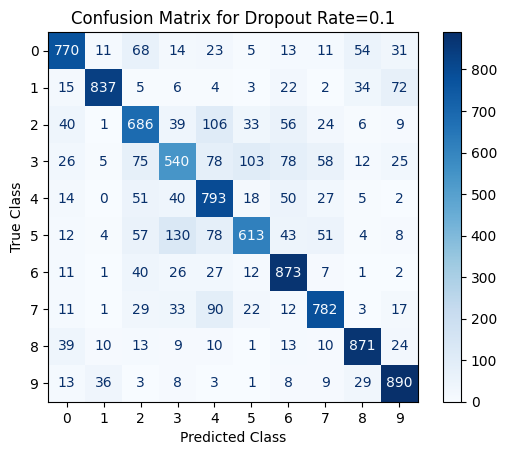

Training model with MaxDropout rate: 0.15


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_192 (Conv2D)             │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_193 (Conv2D)             │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_160               │ (None, 16, 16, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_194 (Conv2D)             │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_161               │ (None, 8, 8, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_195 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_162               │ (None, 4, 4, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_196 (Conv2D)             │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_163               │ (None, 2, 2, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_64 (MaxDropout)     │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_197 (Conv2D)             │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_164               │ (None, 1, 1, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_65 (MaxDropout)     │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_32 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 456,388 (1.74 MB)

 Trainable params: 456,388 (1.74 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:625: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.3169 - loss: 1.8703 - val_accuracy: 0.6077 - val_loss: 1.0939
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - accuracy: 0.6376 - loss: 1.0157 - val_accuracy: 0.6895 - val_loss: 0.8952
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accuracy: 0.7234 - loss: 0.7851 - val_accuracy: 0.6892 - val_loss: 0.9208
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.7763 - loss: 0.6426 - val_accuracy: 0.7442 - val_loss: 0.7649
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.8080 - loss: 0.5430 - val_accuracy: 0.7464 - val_loss: 0.7354
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.8347 - loss: 0.4639 - val_accuracy: 0.7475 - val_loss: 0.7695
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.8619 - loss: 0.3932 - val_accuracy: 0.7429 - val_loss: 0.8492
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.8777 - loss: 0.34

<Figure size 1000x1000 with 0 Axes>

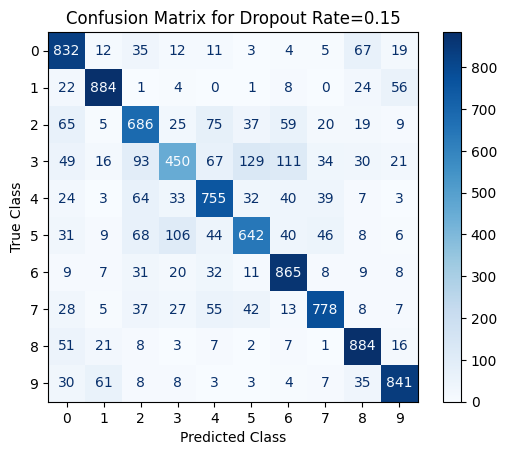

Training model with MaxDropout rate: 0.2


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_198 (Conv2D)             │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_199 (Conv2D)             │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_165               │ (None, 16, 16, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_200 (Conv2D)             │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_166               │ (None, 8, 8, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_201 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_167               │ (None, 4, 4, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_202 (Conv2D)             │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_168               │ (None, 2, 2, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_66 (MaxDropout)     │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_203 (Conv2D)             │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_169               │ (None, 1, 1, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_67 (MaxDropout)     │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_33 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 456,388 (1.74 MB)

 Trainable params: 456,388 (1.74 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:625: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 46s 29ms/step - accuracy: 0.2927 - loss: 1.9402 - val_accuracy: 0.5878 - val_loss: 1.1529
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.6210 - loss: 1.0701 - val_accuracy: 0.6721 - val_loss: 0.9345
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.7221 - loss: 0.7968 - val_accuracy: 0.7064 - val_loss: 0.8706
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - accuracy: 0.7729 - loss: 0.6468 - val_accuracy: 0.7425 - val_loss: 0.7626
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - accuracy: 0.8112 - loss: 0.5467 - val_accuracy: 0.7352 - val_loss: 0.8090
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 44s 28ms/step - accuracy: 0.8369 - loss: 0.4651 - val_accuracy: 0.7648 - val_loss: 0.7336
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - accuracy: 0.8660 - loss: 0.3878 - val_accuracy: 0.7585 - val_loss: 0.7418
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.8844 - loss: 0.33

In [86]:
dropout_rates = [0.1, 0.15, 0.2, 0.25]
all_histories = []
y_train_encoded, y_test_encoded = tf.keras.utils.to_categorical(y_train), tf.keras.utils.to_categorical(y_test)

for rate in dropout_rates:
    print(f"Training model with MaxDropout rate: {rate}")
    model = create_model(rate)

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    history = model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test), callbacks=[tensorboard_callback])
    all_histories.append(history)

    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
    print('\nTest accuracy for rate {}: {}'.format(rate, test_acc))
    # Prediction
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test_encoded, axis=1)

    # Compute the confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    # Display the confusion matrix
    plt.figure(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for Dropout Rate={rate}')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.show()




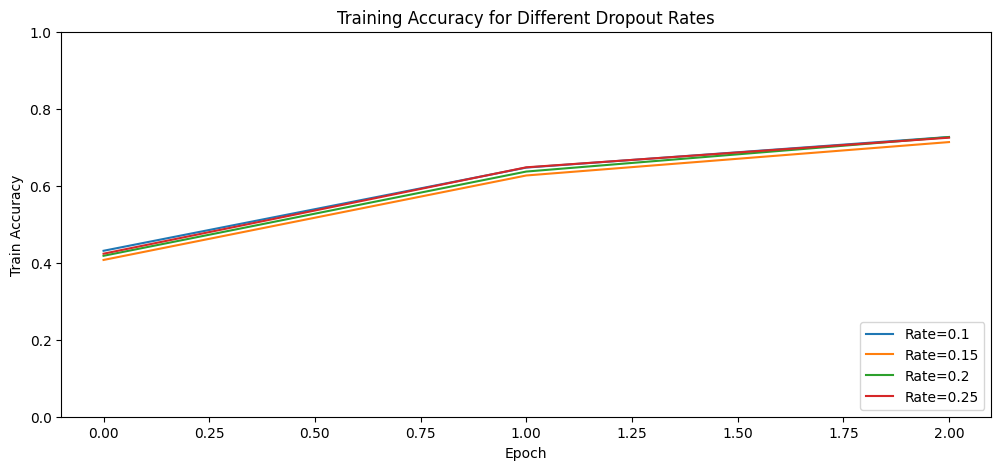

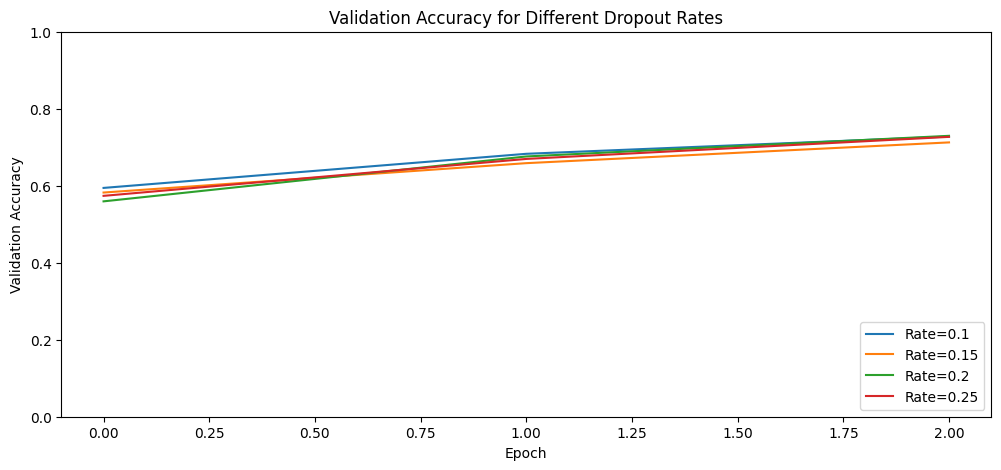

In [67]:
#Plot the accuracies
plt.figure(figsize=(12, 5))
for i, history in enumerate(all_histories):
    plt.plot(history.history['accuracy'], label=f'Rate={dropout_rates[i]}')

plt.title('Training Accuracy for Different Max Dropout Rates')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(12, 5))
for i, history in enumerate(all_histories):
    plt.plot(history.history['val_accuracy'], label=f'Rate={dropout_rates[i]}')

plt.title('Validation Accuracy for Different Max Dropout Rates')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


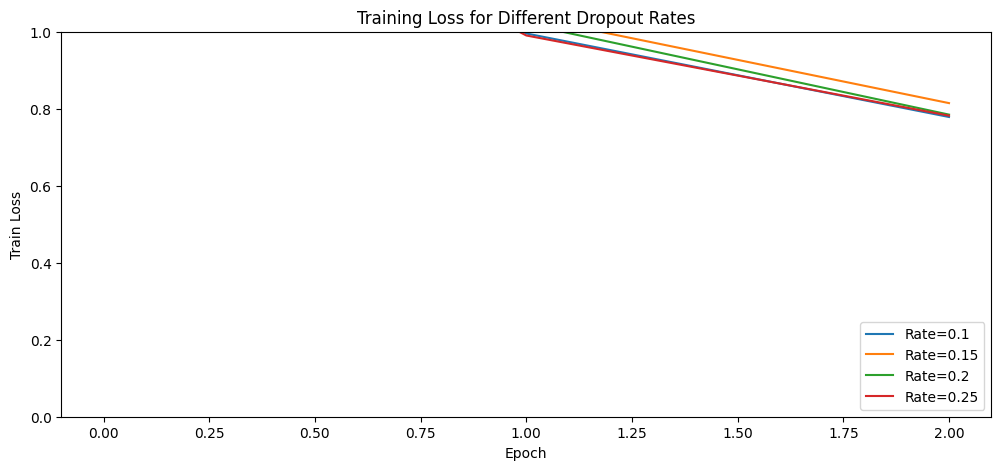

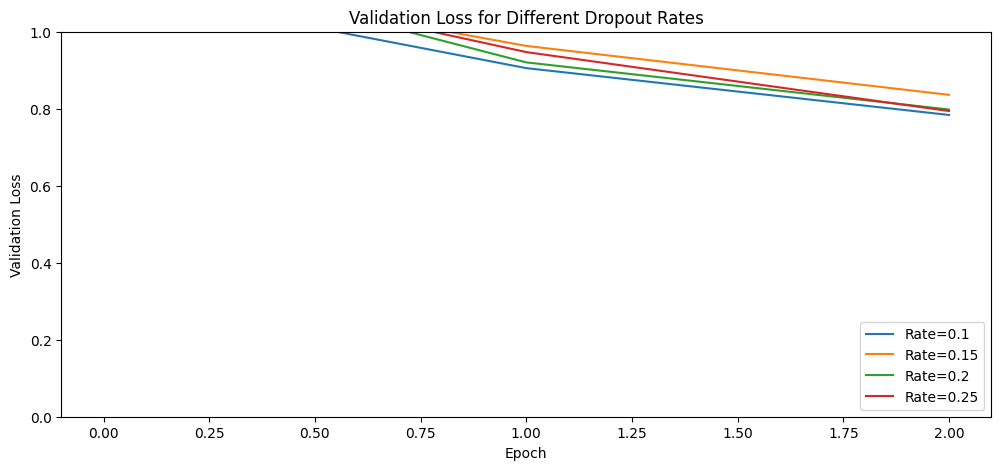

In [68]:
#plot loss
plt.figure(figsize=(12, 5))
for i, history in enumerate(all_histories):
    plt.plot(history.history['loss'], label=f'Rate={dropout_rates[i]}')

plt.title('Training Loss for Different Max Dropout Rates')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(12, 5))
for i, history in enumerate(all_histories):
    plt.plot(history.history['val_loss'], label=f'Rate={dropout_rates[i]}')

plt.title('Validation Loss for Different Max Dropout Rates')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()



## Save the trained Model

In [52]:
#save the trained model (Parameters) so I can use it again without training again
model.save('cifar10_cnn.h5')
#save the trained model (Weights) so I can use it again without training again
model.save('cifar10_cnn_weights.h5')


## Load the trained Model

In [ ]:
#load the trained model (Parameters) so I can use it again without training again
#model = keras.models.load_model('cifar10_cnn.h5')

#load the trained model (Weights) so I can use it again without training again
#model.load_weights('cifar10_cnn_weights.h5')